## Install and import the required modules

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 68.6 MB/s eta 0:00:00


In [ ]:
pip install pyproj

In [ ]:
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
import h5py
from scipy import spatial
import pandas as pd
from osgeo import gdal
import colorsys
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## Calculate the spatial coordinates of the map file



The map file is a colour-coded and georeferenced classification map that is used to correctly label each individual pixel with a correspoding class.

Notably, the satellite raster needs to geospatially overlap with the extent of the map file for the creation of the training set to be successful.

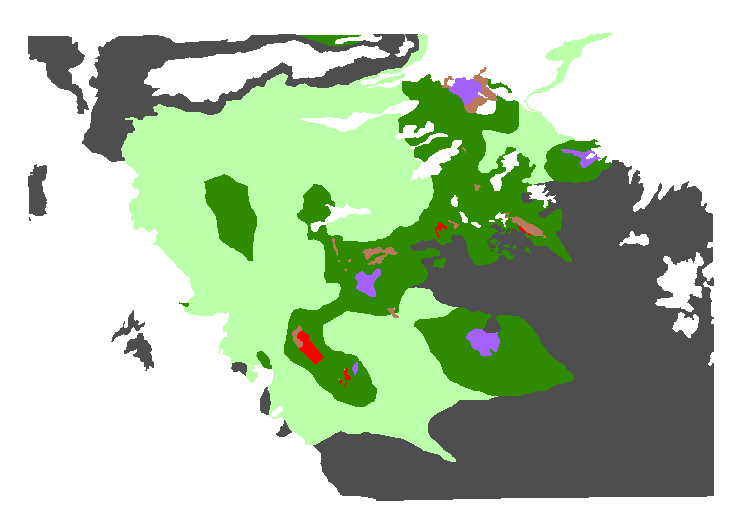

Example of a classification map graphics where each colour represents a distinct class (except for the white background)

In [ ]:
# Adopted/modified from Mike T. at https://gis.stackexchange.com/questions/129847/obtain-coordinates-and-corresponding-pixel-values-from-geotiff-using-python-gdal

# Read the map raster file (.tif file type accepted, georeferencing required!)
# Specify the location of the map file
with rasterio.open('/path/Map_name.tif') as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs) # GIS projection
    A = r.read()  # pixel values (RGB)

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
lon_map, lat_map = transform(p1, p2, eastings, northings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [ ]:
A.shape # Raster RGB values

(3, 1122, 1540)

In [ ]:
lat_map # Latitude for each pixel of the map raster

In [ ]:
lon_map # Longitude for each pixel of the map raster

array([[-70.89132344, -70.89104169, -70.89075993, ..., -70.45821236,
        -70.45793054, -70.45764871],
       [-70.89132617, -70.89104442, -70.89076266, ..., -70.45821446,
        -70.45793264, -70.45765082],
       [-70.8913289 , -70.89104714, -70.89076539, ..., -70.45821657,
        -70.45793474, -70.45765292],
       ...,
       [-70.89440727, -70.89412506, -70.89384284, ..., -70.4605907 ,
        -70.46030842, -70.46002613],
       [-70.89441006, -70.89412784, -70.89384563, ..., -70.46059284,
        -70.46031056, -70.46002828],
       [-70.89441284, -70.89413063, -70.89384841, ..., -70.46059499,
        -70.46031271, -70.46003043]])

## Extract the geospatial and spectral information from PRISMA file

PRISMA basic info:

> "Launched on 22 March, 2019, PRISMA is a medium-resolution hyperspectral imaging satellite, developed, owned and operated by ASI (Agenzia Spaziale Italiana). It is the successor to the discontinued HypSEO (Hyperspectral Satellite for Earth Observation) mission and has a planned mission duration of 5 years."

Source: European Space Agency (link: https://www.eoportal.org/satellite-missions/prisma-hyperspectral#summary)



This part could be modified to data originating from other satellites or sources as long as the equivalent information is extracted, including geospatial coordinates and spectral band values.

In [ ]:
# Load the raw PRISMA satellite data
# Only .he5 hierarchical data type accepted!
prisma_raw = h5py.File('/path/data_file_name.he5','r')

In [ ]:
# Adopted from KuLTiGiNHaN at https://stackoverflow.com/questions/71950493/prisma-satellite-data-projection-problem-when-exporting-as-tiff-in-python
dataset0 = prisma_raw.get('HDFEOS')
dataset1 = dataset0.get('SWATHS')
dataset2 = dataset1.get('PRS_L2D_HCO')
dataset3 = dataset2.get('Data Fields')
dataset4 = dataset2.get('Geolocation Fields')
# Save the geospatial coordinates into a numpy array.
lat = np.array(dataset4.get('Latitude_SWIR'))
lon = np.array(dataset4.get('Longitude_SWIR'))

In [ ]:
lat

array([[-17.057552, -17.057817, -17.05808 , ..., -17.321032, -17.321295,
        -17.32156 ],
       [-17.057497, -17.057762, -17.058025, ..., -17.320974, -17.32124 ,
        -17.321505],
       [-17.057442, -17.057705, -17.05797 , ..., -17.320919, -17.321184,
        -17.321447],
       ...,
       [-17.002209, -17.002472, -17.002735, ..., -17.26545 , -17.265713,
        -17.265978],
       [-17.002153, -17.002417, -17.00268 , ..., -17.265394, -17.265657,
        -17.265923],
       [-17.002096, -17.002361, -17.002625, ..., -17.265337, -17.265602,
        -17.265865]], dtype=float32)

In [ ]:
lon

array([[-70.475334, -70.47539 , -70.47545 , ..., -70.53302 , -70.53307 ,
        -70.533134],
       [-70.47561 , -70.47566 , -70.47572 , ..., -70.533295, -70.53335 ,
        -70.53341 ],
       [-70.47588 , -70.47594 , -70.476   , ..., -70.53357 , -70.53363 ,
        -70.53368 ],
       ...,
       [-70.749054, -70.74911 , -70.74917 , ..., -70.80797 , -70.80802 ,
        -70.80808 ],
       [-70.74933 , -70.74938 , -70.74944 , ..., -70.80824 , -70.808304,
        -70.80836 ],
       [-70.7496  , -70.74966 , -70.74972 , ..., -70.80852 , -70.80858 ,
        -70.80864 ]], dtype=float32)

In [ ]:
# Extract and merge the spectral data (VNIR & SWIR)
merged_vnir_swir = np.concatenate((dataset3.get('VNIR_Cube'), dataset3.get('SWIR_Cube')), axis=1)
merged_vnir_swir = merged_vnir_swir.transpose(0, 2, 1) # Reshape the dataset
merged_vnir_swir.shape # New shape = (raster height [pixels], raster width [pixels], bands)

(1000, 1000, 239)

In [ ]:
# Transform the merged 3-d array into a 2-d array.
height, width, bands_num = merged_vnir_swir.shape
collapsed_vnir_swir = merged_vnir_swir.reshape(height*width, bands_num)
collapsed_vnir_swir.shape # New shape = (pixels, bands)

(1000000, 239)

## Discard datapoints and bands with no spectral information

In [ ]:
# Create a list of band names (e.g., 1_vnir - PRISMA specific!)
band_names = [str(n + 1) + '_VNIR' if n <= 65 else str(n + 1) + '_SWIR' for n in range(merged_vnir_swir.shape[2])]

In [ ]:
# Save the values to a df.
spectral_df = pd.DataFrame(data=collapsed_vnir_swir,columns=band_names)
print(spectral_df.shape)
spectral_df.head()

(1000000, 239)


,1_VNIR,2_VNIR,3_VNIR,4_VNIR,5_VNIR,6_VNIR,7_VNIR,8_VNIR,9_VNIR,10_VNIR,...,230_SWIR,231_SWIR,232_SWIR,233_SWIR,234_SWIR,235_SWIR,236_SWIR,237_SWIR,238_SWIR,239_SWIR
0,0,0,0,324,329,313,332,327,331,319,...,352,366,345,363,347,356,349,361,0,0
1,0,0,0,388,393,371,385,386,421,429,...,431,441,415,430,410,414,402,410,0,0
2,0,0,0,3553,3331,2835,2661,2753,3535,3737,...,3115,3144,3201,3230,3024,2729,2503,2251,0,0
3,0,0,0,3350,3185,2686,2540,3088,3679,3636,...,3248,3342,3369,3401,3217,2897,2667,2408,0,0
4,0,0,0,3142,2928,2543,2530,2838,3367,3446,...,3318,3313,3347,3398,3215,2884,2629,2352,0,0


In [ ]:
# Discard rows and columns that contain only zero values.
spectral_df = spectral_df.loc[(spectral_df!=0).any(1) , (spectral_df != 0).any(0)]
print(spectral_df.shape)
spectral_df.head()

(1000000, 234)


,4_VNIR,5_VNIR,6_VNIR,7_VNIR,8_VNIR,9_VNIR,10_VNIR,11_VNIR,12_VNIR,13_VNIR,...,228_SWIR,229_SWIR,230_SWIR,231_SWIR,232_SWIR,233_SWIR,234_SWIR,235_SWIR,236_SWIR,237_SWIR
0,324,329,313,332,327,331,319,318,317,335,...,349,368,352,366,345,363,347,356,349,361
1,388,393,371,385,386,421,429,436,443,469,...,477,464,431,441,415,430,410,414,402,410
2,3553,3331,2835,2661,2753,3535,3737,4010,4477,4630,...,3146,3151,3115,3144,3201,3230,3024,2729,2503,2251
3,3350,3185,2686,2540,3088,3679,3636,3831,4243,4449,...,3296,3295,3248,3342,3369,3401,3217,2897,2667,2408
4,3142,2928,2543,2530,2838,3367,3446,3665,4140,4219,...,3292,3315,3318,3313,3347,3398,3215,2884,2629,2352


## Calculate the average spectra for the whole scene

In [ ]:
# Average value for each spectral band
scene_mean = spectral_df.mean().ravel()

## Find the nearest point in the alteration map for each PRISMA pixel

In [ ]:
# Adopted from Andrew Lindsay at https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates

# Determine the closest map pixel to each PRISMA raster pixel and calculate the distance between them.
def do_kdtree(x_y_arrays, points):
    mytree = spatial.cKDTree(x_y_arrays)
    dist, indexes = mytree.query(points)
    return indexes, dist

In [ ]:
# Generate arrays of geospatial coordinates of all raster pixels
map_x_y = np.dstack([lat_map.ravel(),lon_map.ravel()])[0] # map
PRISMA_points = np.dstack([lat.ravel(),lon.ravel()])[0] # PRISMA

results, dist_results = do_kdtree(map_x_y, PRISMA_points)

In [ ]:
# Save the index of the nearest map pixel for each PRISMA pixel
nearest_df = pd.DataFrame({
    'Lat_PRISMA': lat.ravel(),
    'Lon_PRISMA': lon.ravel(),
    'Nearest_map_index': results
})
print(nearest_df.shape)
nearest_df.head()

(1000000, 3)


,Lat_PRISMA,Lon_PRISMA,Nearest_map_index
0,-17.057552,-70.475334,32276
1,-17.057817,-70.475388,33816
2,-17.058081,-70.475449,35356
3,-17.058346,-70.475510,36896
4,-17.058609,-70.475563,38436


## Select only the datapoints distanced from their nearest map pixel below or equal to the threshold value

The threshold value is important as it is used to filter pixels that do not overlap between the map and PRISMA raster (distance between pixels > threshold value).

In this case, the threshold value is chosen to represent the distance between centre points of adjacent pixels of the **map** raster.

In [ ]:
# Calculate the distace between centres of 2 adjacent pixels (= threshold value)
# This distance should be equal between all adjacent pixels. Thus, the position of the 2 pixels should not matter.
separation_dist = float(do_kdtree([map_x_y[1]], [map_x_y[2]])[1])
separation_dist # Note: 0.0001° ~ 11.1 meters

0.0002817667358013141

In [ ]:
# Extract only the datapoints located within (i.e. lower than) the threshold distance between the pixel centres.
selected_pixels = nearest_df[dist_results < separation_dist]
print(selected_pixels.shape)
selected_pixels.head()

(918968, 3)


,Lat_PRISMA,Lon_PRISMA,Nearest_map_index
0,-17.057552,-70.475334,32276
1,-17.057817,-70.475388,33816
2,-17.058081,-70.475449,35356
3,-17.058346,-70.475510,36896
4,-17.058609,-70.475563,38436


## Extract the bands of the map image and select the appropriate pixels

In [ ]:
# Sort the rgb values (of the map file) by each band and save them.
map_rgb_df = A.reshape(A.shape[0], A.shape[1]*A.shape[2])
map_rgb_df.shape # New shape = (bands, pixels)

(3, 1727880)

In [ ]:
map_rgb_df

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Extract the position of the nearest map pixels (below the threshold distance).
selected_index = selected_pixels['Nearest_map_index'].values
selected_index

array([  32276,   33816,   35356, ..., 1226141, 1227681, 1229221])

In [ ]:
# Assign rgb values (from the map file) to the corresponding pixels.
selected_pixels['Red_channel'] = np.array([map_rgb_df[0][i] for i in selected_index])
selected_pixels['Green_channel'] = np.array([map_rgb_df[1][i] for i in selected_index])
selected_pixels['Blue_channel'] = np.array([map_rgb_df[2][i] for i in selected_index])
selected_pixels.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Lat_PRISMA,Lon_PRISMA,Nearest_map_index,Red_channel,Green_channel,Blue_channel
0,-17.057552,-70.475334,32276,255,255,255
1,-17.057817,-70.475388,33816,255,255,255
2,-17.058081,-70.475449,35356,255,255,255
3,-17.058346,-70.475510,36896,255,255,255
4,-17.058609,-70.475563,38436,255,255,255


## Calculate the hues of the map pixels and assign it to the selected PRISMA datapoints

In [ ]:
# Reshape the rbg values by each map pixel.
stacked_rgb = np.dstack([selected_pixels['Red_channel'].values,
           selected_pixels['Green_channel'].values,
           selected_pixels['Blue_channel'].values])[0]
stacked_rgb.shape # new shape = (pixels, bands)

(918968, 3)

In [ ]:
# Calculate hue, luminosity, and saturation from rgb (of the nearest map pixels).
stacked_hls = np.array(list(map(lambda rgb: colorsys.rgb_to_hls(rgb[0]/255,
                                             rgb[1]/255, rgb[2]/255), stacked_rgb))) # All of the hls values are between 0 to 1

In [ ]:
# Convert the hsl output to real values
selected_pixels.loc[:, 'Hue'] = stacked_hls.T[0] * 360 # degrees
selected_pixels.loc[:, 'Luminosity'] = stacked_hls.T[1] * 100 # percent
selected_pixels.loc[:, 'Saturation'] = stacked_hls.T[2] * 100 # percent
selected_pixels

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Lat_PRISMA,Lon_PRISMA,Nearest_map_index,Red_channel,Green_channel,Blue_channel,Hue,Luminosity,Saturation
0,-17.057552,-70.475334,32276,255,255,255,0.0,100.0,0.0
1,-17.057817,-70.475388,33816,255,255,255,0.0,100.0,0.0
2,-17.058081,-70.475449,35356,255,255,255,0.0,100.0,0.0
3,-17.058346,-70.475510,36896,255,255,255,0.0,100.0,0.0
4,-17.058609,-70.475563,38436,255,255,255,0.0,100.0,0.0
...,...,...,...,...,...,...,...,...,...
999995,-17.264811,-70.808403,1223062,255,255,255,0.0,100.0,0.0
999996,-17.265074,-70.808456,1224602,255,255,255,0.0,100.0,0.0
999997,-17.265337,-70.808517,1226141,255,255,255,0.0,100.0,0.0
999998,-17.265602,-70.808578,1227681,255,255,255,0.0,100.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a0c0e2650>]],
      dtype=object)

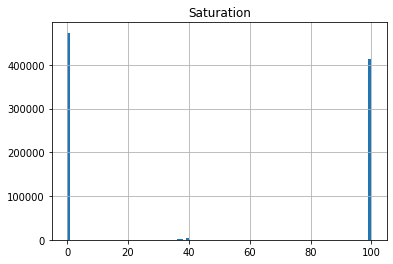

In [ ]:
selected_pixels.hist(column='Saturation', bins=100)

## Add the PRISMA data to the matched pixels

Create a merged dataframe with the location and PRISMA spectral data as well as the RGB values of the nearest map pixels. Note that the pixels with bigger than the threshold distance and pixels that do not contain valid spectral information are **excluded** during the merging process.

In [ ]:
# Assign the PRISMA (or other satelite) data to the selected map pixels.
unified_df = pd.concat([selected_pixels, spectral_df], axis=1, join="inner") # Inner merge - only selected pixels that contain spectral information (do not contain all zero values).
unified_df

,Lat_PRISMA,Lon_PRISMA,Nearest_map_index,Red_channel,Green_channel,Blue_channel,Hue,Luminosity,Saturation,4_VNIR,...,228_SWIR,229_SWIR,230_SWIR,231_SWIR,232_SWIR,233_SWIR,234_SWIR,235_SWIR,236_SWIR,237_SWIR
0,-17.057552,-70.475334,32276,255,255,255,0.0,100.0,0.0,324,...,349,368,352,366,345,363,347,356,349,361
1,-17.057817,-70.475388,33816,255,255,255,0.0,100.0,0.0,388,...,477,464,431,441,415,430,410,414,402,410
2,-17.058081,-70.475449,35356,255,255,255,0.0,100.0,0.0,3553,...,3146,3151,3115,3144,3201,3230,3024,2729,2503,2251
3,-17.058346,-70.475510,36896,255,255,255,0.0,100.0,0.0,3350,...,3296,3295,3248,3342,3369,3401,3217,2897,2667,2408
4,-17.058609,-70.475563,38436,255,255,255,0.0,100.0,0.0,3142,...,3292,3315,3318,3313,3347,3398,3215,2884,2629,2352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-17.264811,-70.808403,1223062,255,255,255,0.0,100.0,0.0,3965,...,4264,4277,4268,4359,4320,4079,3600,2708,2327,1938
999996,-17.265074,-70.808456,1224602,255,255,255,0.0,100.0,0.0,3778,...,4103,4149,4205,4255,4180,3934,3487,2711,2228,1952
999997,-17.265337,-70.808517,1226141,255,255,255,0.0,100.0,0.0,3923,...,4296,4342,4389,4427,4380,4166,3651,2776,2362,2015
999998,-17.265602,-70.808578,1227681,255,255,255,0.0,100.0,0.0,4109,...,4511,4628,4631,4702,4660,4454,3909,2921,2499,2111


## Isolate datapoints with equal colour properties (i.e. hue, luminosity, and saturation) from the map file that are associated with a distinct class

In [ ]:
# Display dataframe values in float format using 3 decimal spaces.
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Extract pixels based on their hls values.
class_one = unified_df[((unified_df['Hue'] >= 99) & (unified_df['Hue'] <= 101)) &
                       ((unified_df['Luminosity'] >= 27) & (unified_df['Luminosity'] <= 28)) &
                       ((unified_df['Saturation'] >= 99) & (unified_df['Saturation'] <= 100))]
class_one[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,149026.000,149026.000,149026.000
mean,100.000,27.059,100.000
std,0.000,0.000,0.000
min,100.000,27.059,100.000
25%,100.000,27.059,100.000
50%,100.000,27.059,100.000
75%,100.000,27.059,100.000
max,100.000,27.059,100.000


In [ ]:
class_two = unified_df[((unified_df['Hue'] >= 107.8) & (unified_df['Hue'] <= 107.9)) &
                       ((unified_df['Luminosity'] >= 83.5) & (unified_df['Luminosity'] <= 83.6)) &
                       ((unified_df['Saturation'] >= 100) & (unified_df['Saturation'] <= 100))]
class_two[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,248490.000,248490.000,248490.000
mean,107.857,83.529,100.000
std,0.000,0.000,0.000
min,107.857,83.529,100.000
25%,107.857,83.529,100.000
50%,107.857,83.529,100.000
75%,107.857,83.529,100.000
max,107.857,83.529,100.000


In [ ]:
class_three = unified_df[((unified_df['Hue'] >= 265.5) & (unified_df['Hue'] <= 266)) &
                       ((unified_df['Luminosity'] >= 69) & (unified_df['Luminosity'] <= 69.2)) &
                       ((unified_df['Saturation'] >= 99) & (unified_df['Saturation'] <= 100))]
class_three[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,6828.000,6828.000,6828.000
mean,265.823,69.020,100.000
std,0.000,0.000,0.000
min,265.823,69.020,100.000
25%,265.823,69.020,100.000
50%,265.823,69.020,100.000
75%,265.823,69.020,100.000
max,265.823,69.020,100.000


In [ ]:
class_four = unified_df[((unified_df['Hue'] >= 0) & (unified_df['Hue'] <= 20)) &
                       ((unified_df['Luminosity'] >= 10) & (unified_df['Luminosity'] <= 40)) &
                       ((unified_df['Saturation'] >= 0) & (unified_df['Saturation'] <= 100))]
class_four[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,204012.000,204012.000,204012.000
mean,0.012,30.613,0.081
std,0.424,0.380,2.804
min,0.000,30.588,0.000
25%,0.000,30.588,0.000
50%,0.000,30.588,0.000
75%,0.000,30.588,0.000
max,20.000,40.000,100.000


In [ ]:
class_five = unified_df[((unified_df['Hue'] >= 0) & (unified_df['Hue'] <= 0)) &
                       ((unified_df['Luminosity'] >= 50) & (unified_df['Luminosity'] <= 50)) &
                       ((unified_df['Saturation'] >= 100) & (unified_df['Saturation'] <= 100))]
class_five[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,1705.000,1705.000,1705.000
mean,0.000,50.000,100.000
std,0.000,0.000,0.000
min,0.000,50.000,100.000
25%,0.000,50.000,100.000
50%,0.000,50.000,100.000
75%,0.000,50.000,100.000
max,0.000,50.000,100.000


In [ ]:
class_six = unified_df[((unified_df['Hue'] >= 10) & (unified_df['Hue'] <= 40)) &
                       ((unified_df['Luminosity'] >= 40) & (unified_df['Luminosity'] <= 60)) &
                       ((unified_df['Saturation'] >= 30) & (unified_df['Saturation'] <= 70))]
class_six[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,5115.000,5115.000,5115.000
mean,20.103,53.519,39.011
std,4.078,2.192,1.767
min,10.233,41.569,30.612
25%,18.913,54.118,39.316
50%,18.913,54.118,39.316
75%,18.913,54.118,39.316
max,40.000,60.000,66.038


In [ ]:
class_seven = unified_df[((unified_df['Hue'] >= -1) & (unified_df['Hue'] <= 10)) &
                       ((unified_df['Luminosity'] >= 30.5) & (unified_df['Luminosity'] <= 30.6)) &
                       ((unified_df['Saturation'] >= -1) & (unified_df['Saturation'] <= 20))]
class_seven[['Hue', 'Luminosity', 'Saturation']].describe()

,Hue,Luminosity,Saturation
count,202841.000,202841.000,202841.000
mean,0.000,30.588,0.000
std,0.000,0.000,0.000
min,0.000,30.588,0.000
25%,0.000,30.588,0.000
50%,0.000,30.588,0.000
75%,0.000,30.588,0.000
max,0.000,30.588,0.000


## Test the selection of the datapoints by creating a mask

The mask will show the spatial extent of the isolated pixels assigned to a single class. This image can be then compared to the original map file and check if the pixels were assigned correctly.

In [ ]:
# Extract the selected pixels' position on the alteration map
new_index = class_one['Nearest_map_index'].values

# Create a mask with the same dimensions as the alteration map with all zero values.
mask_array = np.array([0 for i in range(len(map_rgb_df[0]))])
# Change the mask values for the selected pixels.
for y in new_index: #  Note: for loo could be replaced by a map function for greater efficiency
  mask_array[y] = 1

# Multiply the alteration map by the mask.
masked_map = map_rgb_df[1]*mask_array # You can change the displayed band by changing the index (R-0, G-1 or B-2)
masked_map = np.array(masked_map.reshape(A.shape[1], A.shape[2]), dtype=np.uint8)

# Export the image with only the selected pixels being shown (rest is black).
from PIL import Image
img = Image.fromarray(masked_map)
img.save('Quellaveco_chloritic_zone.png')

In [ ]:
masked_map.shape

(1122, 1540)

## Create the training dataset

In [ ]:
# Name the individual classes for the tranining dataset. Example:
class_names = [propylitic_zone, chloritic_zone, phyllic_zone,
                    advanced_argillic_zone, unaltered_zone]

In [ ]:
# Merge the extracted datasets assigned to each class and add a classification column.
training_df = pd.concat(alteration_zones, keys=['propylitic', 'chloritic',
                                                'phyllic', 'advanced_argillic', 'unaltered']).reset_index()
training_df

,level_0,level_1,Lat_PRISMA,Lon_PRISMA,Nearest_map_index,Red_channel,Green_channel,Blue_channel,Hue,Luminosity,...,228_SWIR,229_SWIR,230_SWIR,231_SWIR,232_SWIR,233_SWIR,234_SWIR,235_SWIR,236_SWIR,237_SWIR
0,propylitic,141810,-17.264,-70.561,1206998,46,138,0,100.000,27.059,...,2597,2661,2684,2717,2714,2727,2422,2021,1786,1547
1,propylitic,141811,-17.264,-70.561,1208538,46,138,0,100.000,27.059,...,2842,2878,2886,2950,2966,2930,2675,2233,1935,1708
2,propylitic,142806,-17.263,-70.561,1200838,46,138,0,100.000,27.059,...,2260,2298,2279,2273,2288,2291,2112,1766,1526,1330
3,propylitic,142807,-17.263,-70.561,1202378,46,138,0,100.000,27.059,...,2526,2541,2549,2592,2595,2601,2349,1929,1705,1499
4,propylitic,142808,-17.263,-70.561,1203918,46,138,0,100.000,27.059,...,2896,2941,2901,2943,2973,2962,2673,2226,1969,1729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608885,unaltered,999954,-17.254,-70.806,1161470,78,78,78,0.000,30.588,...,4342,4371,4413,4534,4464,4248,3787,2867,2372,2057
608886,unaltered,999955,-17.254,-70.806,1163010,78,78,78,0.000,30.588,...,4010,4054,4127,4173,4129,3991,3554,2601,2285,1974
608887,unaltered,999956,-17.255,-70.806,1164550,78,78,78,0.000,30.588,...,3702,3699,3733,3821,3783,3614,3181,2453,2053,1739
608888,unaltered,999957,-17.255,-70.806,1166089,78,78,78,0.000,30.588,...,3509,3506,3547,3675,3615,3371,3008,2321,1886,1560


In [ ]:
# See the count of datapoints sorted by each class present in the training dataset.
# This information is important to assess how balanced the dataset is.
training_df.level_0.value_counts()

chloritic            248490
unaltered            202841
propylitic           149026
phyllic                6828
advanced_argillic      1705
Name: level_0, dtype: int64

In [ ]:
# Remove the excessive columns (leave only the classified satellite data).
training_df.drop(training_df.iloc[:, 1:11], axis=1, inplace=True)
# Rename the classification column.
training_df.rename(columns = {'level_0':'Alteration_zone'}, inplace = True)
training_df

,Alteration_zone,4_VNIR,5_VNIR,6_VNIR,7_VNIR,8_VNIR,9_VNIR,10_VNIR,11_VNIR,12_VNIR,...,228_SWIR,229_SWIR,230_SWIR,231_SWIR,232_SWIR,233_SWIR,234_SWIR,235_SWIR,236_SWIR,237_SWIR
0,propylitic,2428,2198,1841,1648,1906,2512,2582,2742,3107,...,2597,2661,2684,2717,2714,2727,2422,2021,1786,1547
1,propylitic,2607,2365,1994,1781,1991,2686,2778,2910,3322,...,2842,2878,2886,2950,2966,2930,2675,2233,1935,1708
2,propylitic,2199,2015,1702,1511,1707,2279,2360,2474,2830,...,2260,2298,2279,2273,2288,2291,2112,1766,1526,1330
3,propylitic,2458,2242,1882,1697,1942,2575,2657,2783,3187,...,2526,2541,2549,2592,2595,2601,2349,1929,1705,1499
4,propylitic,2831,2573,2177,1931,2195,2939,3039,3181,3646,...,2896,2941,2901,2943,2973,2962,2673,2226,1969,1729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608885,unaltered,4010,3286,2490,2221,2601,4251,4205,4554,5441,...,4342,4371,4413,4534,4464,4248,3787,2867,2372,2057
608886,unaltered,3697,3028,2294,2110,2449,3928,3934,4244,5032,...,4010,4054,4127,4173,4129,3991,3554,2601,2285,1974
608887,unaltered,3404,2832,2208,1944,2270,3734,3697,3967,4704,...,3702,3699,3733,3821,3783,3614,3181,2453,2053,1739
608888,unaltered,3238,2704,2013,1833,2193,3476,3438,3726,4425,...,3509,3506,3547,3675,3615,3371,3008,2321,1886,1560


In [ ]:
training_df.isna().sum().sum() # Check for missing values (should be 0).

0

## Save the dataset (in CSV format)

In [ ]:
training_df.to_csv('/path/labelled_training_dataset',index=False)